# Introduction

The objective of this project is to create a machine learning model able to predict books rating scores given their other features. The dataset used to train the model was collected on the website goodreads.com. This website consists in aggregating book reviews from readers on the web. The final model should be able to take as input the features selected for training amongst the dataset’s features and predict a rating score as close as possible to its real score.

# Data exploratory analysis
Given the source of the data, many features are provided with the rating score that needs to be predicted. The first step is to load the data and look at its shape and what features it contains.


In [34]:
# Necessary imports for the whole notebook
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt


## Reading the data


In [35]:
# Use the following line to browse and select the CSV file "books.csv"
uploaded = files.upload()

# Get the file name of the uploaded CSV
file_name = list(uploaded.keys())[0]

# Read the CSV file using pandas
try:
    data = pd.read_csv(file_name,delimiter=',', error_bad_lines=False)
except FileNotFoundError:
    print("File not found. Please make sure to select the correct file.")
    exit()

# Display the first 5 rows
data.head()

Saving books.csv to books (1).csv


<ipython-input-35-c661d96dbca4>:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_name,delimiter=',', error_bad_lines=False)
Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


We can see in the first 5 row that the data contains 13 columns, including ***average_rating*** that the model should predict in the end.

---

## Cleaning the data

The goal of this step is to handle missing values, duplicates, and outliers.

In [36]:
# Check for missing values
print(data.isnull().sum())

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


In [37]:
# Check for duplicates
print(data.duplicated().sum())

0


The dataset did not contain any missing value nor duplicate.

In [38]:
# Display unique values of the column 'language_code'
language_code = data['language_code'].unique()

language_code

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla',
       'ale'], dtype=object)

As we can see in the ***language_code*** column, the english language can be encoded in several different ways depending of its country of origin. Encoding can lead to a large number of columns if we have many unique categories. This can increase the dimensionality of our data and negatively impact the performance of a machine learning model.

For this reason, we combined all english codes in one value 'eng'.

In [39]:
data['language_code'] = data['language_code'].replace(["en-US","en-CA","en-GB"],"eng")

data['language_code'].unique()

array(['eng', 'fre', 'spa', 'mul', 'grc', 'enm', 'ger', 'jpn', 'ara',
       'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg',
       'wel', 'swe', 'nor', 'tur', 'gla', 'ale'], dtype=object)

We have added the 'num_authors' feature since we might find that books with certain combinations of authors tend to have higher or lower ratings. By creating this new feature, we can better analyze the impact of both the primary and secondary authors on ratings.

In [40]:
# Count the number of authors (assuming they are separated by "/")
data['num_authors'] = data['authors'].apply(lambda x: len(x.split('/')))

data.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,num_authors
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,2
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,2
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,1
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,2
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,2


There are some quick fixes to be made on the columns names or the value types.

In [41]:
# Fix the column name for num_pages
data = data.rename(columns={'  num_pages': 'num_pages'})

# Convert num_pages to integer
data['num_pages'] = data['num_pages'].astype(int)

# Convert average_rating to float
data['average_rating'] = data['average_rating'].astype(float)

From the ***publication_date*** column we extract a new column ***year*** for it to be usable by the model.

In [42]:
# Convert date string to a datatime format
def clean_and_convert_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except ValueError:
        return None  # Return None for invalid dates

data = data.copy()
data['publication_date'] = data['publication_date'].apply(clean_and_convert_date)

# Extract year from publication_date
data['year'] = data['publication_date'].dt.year

In [43]:
# create 'df', 'df2', 'df3 and'df4' variables to keep 'data' variable raw
df = data.copy()
df2 = data.copy()
df3 = data.copy()
df4 = data.copy()

We then perform a time series analysis on the data and visualize **the average rating over time :**

We resample the data to a specific frequency (yearly) and calculated the average rating for each year.

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

def clean_and_convert_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except ValueError:
        return None  # Return None for invalid dates

df4['publication_date'] = df4['publication_date'].apply(clean_and_convert_date)

df4.set_index('publication_date', inplace=True)

resampled_data = df4['average_rating'].resample('Y').mean()


# Fill missing values using forward fill
resampled_data = resampled_data.ffill()
# Decompose the time series into its components
decomposition = seasonal_decompose(resampled_data, model='additive')


(array([-32872., -25567., -18263., -10958.,  -3653.,   3652.,  10957.,
         18262.,  25567.]),
 [Text(-32872.0, 0, '1880'),
  Text(-25567.0, 0, '1900'),
  Text(-18263.0, 0, '1920'),
  Text(-10958.0, 0, '1940'),
  Text(-3653.0, 0, '1960'),
  Text(3652.0, 0, '1980'),
  Text(10957.0, 0, '2000'),
  Text(18262.0, 0, '2020'),
  Text(25567.0, 0, '2040')])

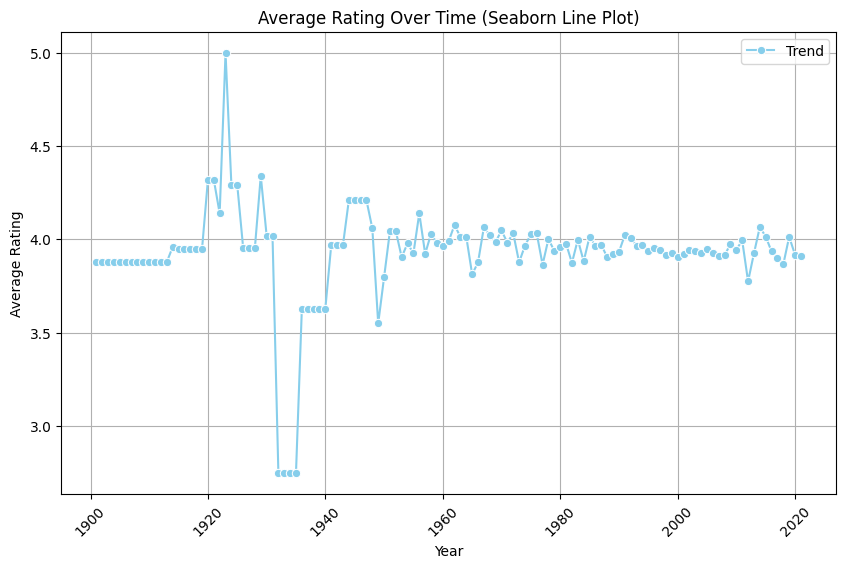

In [45]:
# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(decomposition.trend, label='Trend', marker='o', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time (Seaborn Line Plot)')
plt.grid(True)
plt.xticks(rotation=45)

### Potential Bias
We can see that there are significant fluctuations in the average rating depending on the year of review. But this be biased due to the number of books rated each year. For example, a year with a low number of ratings could have a high mean rating due to a small sample size of positive ratings.

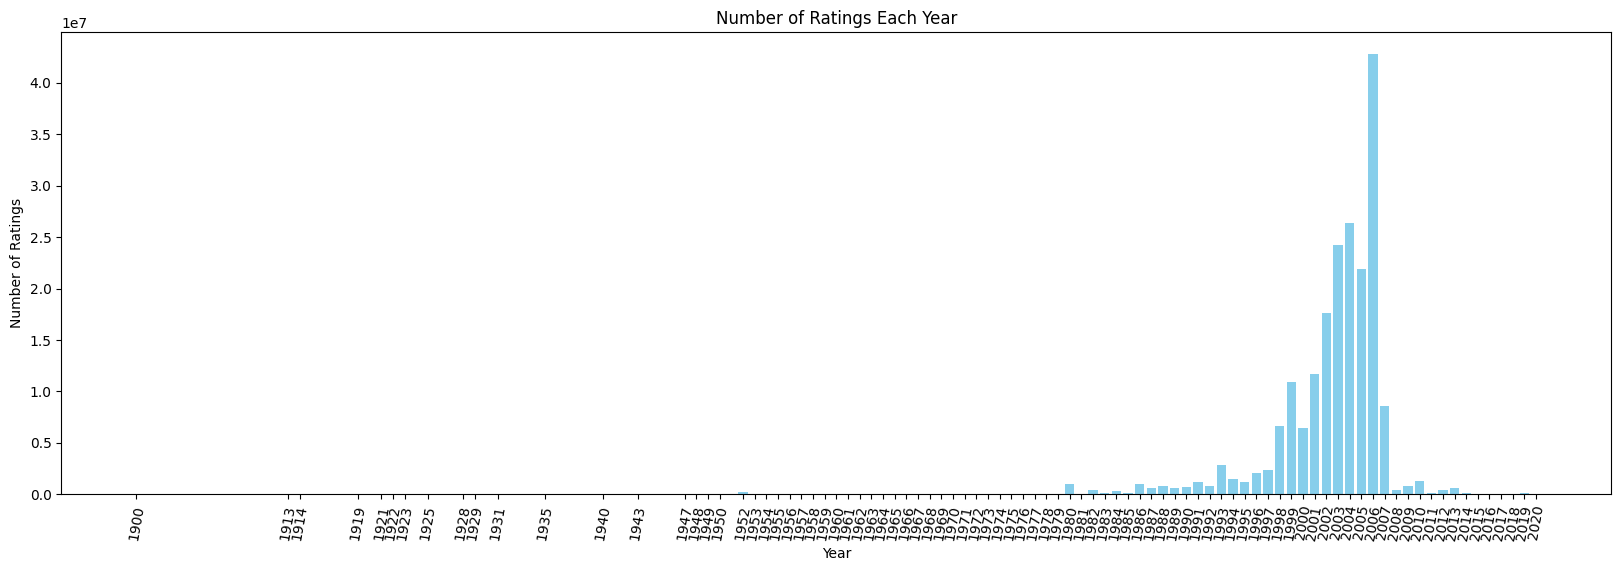

In [46]:
grouped = df4.groupby('year')['ratings_count'].sum().reset_index()

plt.figure(figsize=(20, 6))
plt.bar(grouped['year'], grouped['ratings_count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings Each Year')
plt.xticks(grouped['year'],rotation = 80)
plt.show()

Here we see that the number of reviews indeed varies a lot depending on the year. <br>
Calculating the mean rating for each year without considering the count of books can provide us with insights on the overall average rating trend across the years. Therefore, it's important to note that the interpretation can be affected by the potential variations in **the number of books rated each year**.

**Solution**

To address the potential bias introduced by variations in the number of ratings each year, we can consider calculating weighted averages. Weighted averages take into account the number of ratings when calculating the average rating for each year. This helps give more weight to years with a larger number of ratings, making the average rating more representative of the overall sentiment.

The idea is to calculate the weighted rating for each book by multiplying the rating by the count, then group by year to calculate the sum of weighted ratings and total count of ratings for each year. Finally, divide the sum of weighted ratings by the total count to get the weighted average rating.

(array([1880., 1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(1880.0, 0, '1880'),
  Text(1900.0, 0, '1900'),
  Text(1920.0, 0, '1920'),
  Text(1940.0, 0, '1940'),
  Text(1960.0, 0, '1960'),
  Text(1980.0, 0, '1980'),
  Text(2000.0, 0, '2000'),
  Text(2020.0, 0, '2020'),
  Text(2040.0, 0, '2040')])

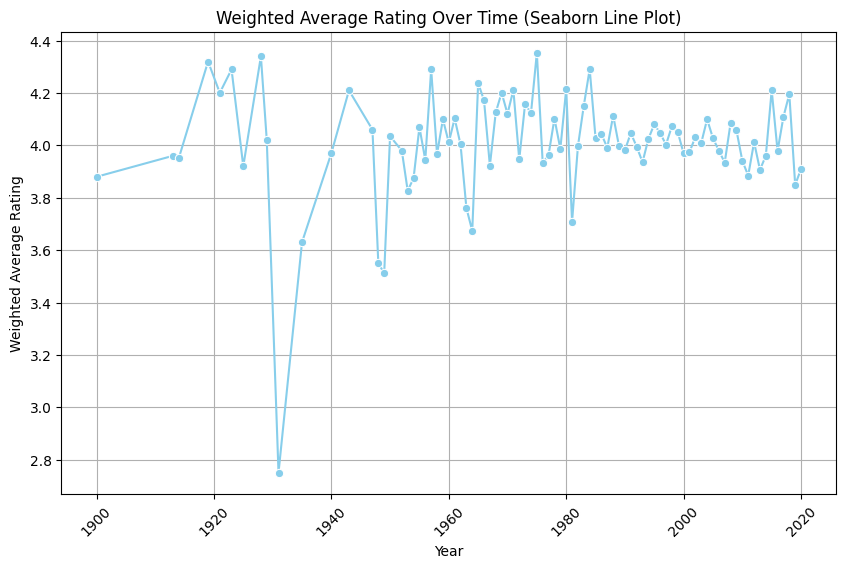

In [47]:
def clean_and_convert_date(date_str):
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except ValueError:
        return None  # Return None for invalid dates

df4 = data.copy()
df4['publication_date'] = df4['publication_date'].apply(clean_and_convert_date)

# Group by year and calculate the weighted average rating
df4['year'] = df4['publication_date'].dt.year
df4['weighted_rating'] = df4['average_rating'] * df4['ratings_count']
weighted_avg_ratings = df4.groupby('year')['weighted_rating'].sum() / df4.groupby('year')['ratings_count'].sum()

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=weighted_avg_ratings.index, y=weighted_avg_ratings.values, marker='o', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Weighted Average Rating')
plt.title('Weighted Average Rating Over Time (Seaborn Line Plot)')
plt.grid(True)
plt.xticks(rotation=45)

So here, we can clearly observe how the variations in average rating have decreased.

In the next steps we will not use the weighted average rating since the average rating is the target the model should predict.

---

## Data encoding

Categorical variables like language, authors and publisher now need to be encoded in order to use them for a predictive model. Encoding can be done using several techniques such as Target Encoding, Frequency or Count Encoding and One-hot encoding

### One-hot encoding<br>
One-hot encoding is employed to transform categorical variables into a binary format, where distinct categories are represented by individual binary columns

In [48]:
# Perform one-hot encoding
encoded_df3 = pd.get_dummies(df3)

encoded_df3.shape

(11123, 30433)

### Frequency Encoding
Frequency encoding replaces categories with their frequency or count in the dataset.

In [49]:
# Perform Frequency Encoding
freq_encoding_map = df2['language_code'].value_counts().to_dict()
df2['language_encoded'] = df2['language_code'].map(freq_encoding_map)

freq_encoding_map = df2['publisher'].value_counts().to_dict()
df2['publisher_encoded'] = df2['publisher'].map(freq_encoding_map)

freq_encoding_map = df2['num_authors'].value_counts().to_dict()
df2['num_authors_encoded'] = df2['num_authors'].map(freq_encoding_map)

freq_encoding_map = df2['authors'].value_counts().to_dict()
df2['authors_encoded'] = df2['authors'].map(freq_encoding_map)

df2.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,num_authors,year,language_encoded,publisher_encoded,num_authors_encoded,authors_encoded
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2,2006.0,10537,13,3078,6
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2,2004.0,10537,13,3078,6
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,1,2003.0,10537,33,6561,11
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,2,2004.0,10537,13,3078,6
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,2,2004.0,10537,33,3078,6


### Target Encoding

Target encoding replaces categorical values with the average target value for each category. This can work well when the category's average target value is informative.

In [17]:
# Perform Target Encoding
encoding_map = df.groupby('language_code')['average_rating'].mean().to_dict()
df['language_encoded'] = df['language_code'].map(encoding_map)

encoding_map = df.groupby('publisher')['average_rating'].mean().to_dict()
df['publisher_encoded'] = df['publisher'].map(encoding_map)

encoding_map = df.groupby('num_authors')['average_rating'].mean().to_dict()
df['num_authors_encoded'] = df['num_authors'].map(encoding_map)


encoding_map = df.groupby('authors')['average_rating'].mean().to_dict()
df['authors_encoded'] = df['authors'].map(encoding_map)

df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,num_authors,year,language_encoded,publisher_encoded,num_authors_encoded,authors_encoded
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2,2006.0,3.931313,4.059231,3.954529,4.548333
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2,2004.0,3.931313,4.059231,3.954529,4.548333
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic,1,2003.0,3.931313,3.975758,3.912481,4.513636
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,2,2004.0,3.931313,4.059231,3.954529,4.548333
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,2,2004.0,3.931313,3.975758,3.954529,4.548333


We can now check the correlation between features before and after apply the encoding



In our case of study, we have various features like "authors", "publisher" ,"average rating," "number of pages," "rating count," "text review count," etc. Checking correlations between variables in our case of study is important because it helps us to understand how different attributes of the book rating are related to each other.<br>

  This understanding can guide our feature selection, model building, and analysis process. Correlation analysis can reveal patterns, dependencies, and potential multicollinearity issues that might affect the accuracy and interpretability of our final model.



*In a correlation plot or heatmap, darker colors usually indicate higher correlation values. The correlation values range between -1 and 1.*



<ipython-input-18-7b19857d0d4f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap="coolwarm", ax=ax1)
<ipython-input-18-7b19857d0d4f>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df2.corr(), annot=True, cmap="coolwarm", ax=ax2)
<ipython-input-18-7b19857d0d4f>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm", ax=ax3)


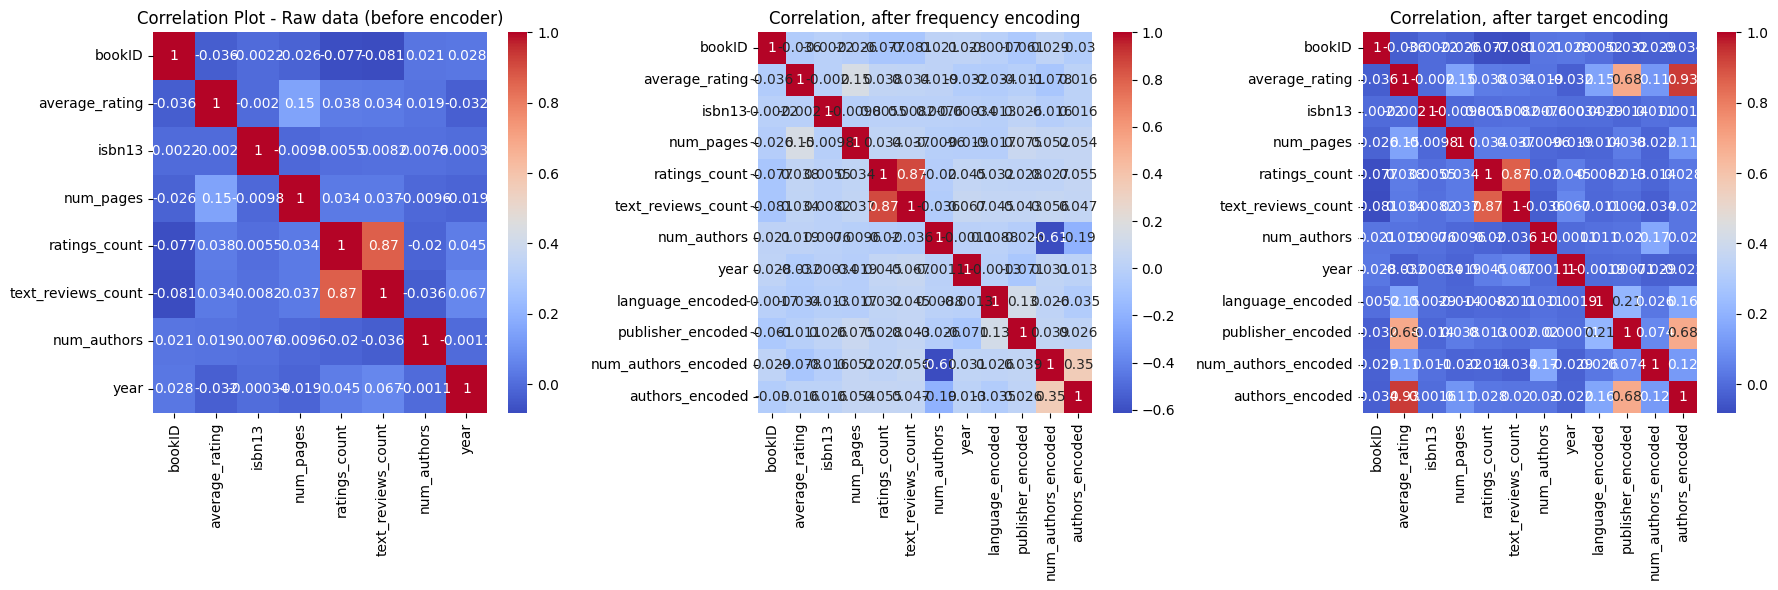

In [18]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot correlation heatmaps
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", ax=ax1)
ax1.set_title("Correlation Plot - Raw data (before encoder)")

sns.heatmap(df2.corr(), annot=True, cmap="coolwarm", ax=ax2)
ax2.set_title("Correlation, after frequency encoding")

sns.heatmap(df.corr(), annot=True, cmap="coolwarm", ax=ax3)
ax3.set_title("Correlation, after target encoding")

# Adjust layout
plt.tight_layout()

# Display the subplots
plt.show()


Now We have experimented with 3 different encoders to assess their impact on the data and how they can influence the results :<br><br>

**One-hot encoding** this approach led to a substantial increase in the number of our resulting columns. When dealing with numerous unique categories across multiple columns, this elevation in dimensionality could potentially affect the performance of our machine learning models, it wasn't effective in our scenario. *The correlation plot isn't shown due to the number of features*

**Frequency or Count Encoding:**
The original categorical variables had similar patterns and distributions, frequency encoding did not introduce new patterns and relationships that affect the correlation (see the correlation plot). We can observe that the correlation remains unchanged, similar to that of the raw data where is no correlation between 'average rating' the other features.


**Target encoding** : In our case Target encoding is very effective since there's a correlation between our categorical features and the target variable 'rating_average', where A higher correlation was shown between the target variable 'rating average' and the features 'author encoded' and 'publisher encoded,' with correlation coefficients of 0.93 and 0.68, respectively.


 By incorporating information from the target variable into the encoding process, target encoding can help capture underlying patterns and relationships in the data that might be relevant for your predictive model.





> Based on the correlation plot, it is evident that the **target encoding** emerged as the most optimal encoding technique for our specific case.




# **Feature Selection**




Based on our correlation analysis , we decided to further refine our feature set by selecting the most relevant features for our prediction task. This will help improve our model performance and reduce overfitting.
so we have set the correlation treshold to 0.5 and we :

1. Calculated the correlation matrix of our features with the target variable ("rating average" in our case).
2. Identified the features that have high correlation values (positive or negative) with the target variable.
3.Kept only those with 0.5 correlation or more and discarded the rest.

In [19]:
correlation_matrix = df.corr()

# Set the correlation threshold
correlation_threshold = 0.5  # Adjust this threshold as needed

# Find features with high correlation with the target variable
high_correlation_features = correlation_matrix['average_rating'][
    (correlation_matrix['average_rating'] > correlation_threshold) |
    (correlation_matrix['average_rating'] < - correlation_threshold)
]

# Keep only the selected high correlation features
selected_features = high_correlation_features.index.tolist()
# Create a new DataFrame with only the selected features
data_selected = df[selected_features]

data_selected.head()


<ipython-input-19-53790c61faa8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,average_rating,publisher_encoded,authors_encoded
0,4.57,4.059231,4.548333
1,4.49,4.059231,4.548333
2,4.42,3.975758,4.513636
3,4.56,4.059231,4.548333
4,4.78,3.975758,4.548333


# **Model Building**

Now that the data is cleaned and encoded properly, that the features have been selected, it's time to build the machine learning models.
We will try several models and compare how they score to select the best one.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [21]:
# Function to train and evaluate a model
def evaluate_model(name, y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return pd.DataFrame({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }, index=[0])

In [22]:
models_scores = pd.DataFrame()

## Linear Regression

In [23]:
# Separate features and target variable
X = data_selected.drop(columns=['average_rating'])
y = data_selected['average_rating']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a linear regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linear_model.predict(X_test)

# Evaluate the model
model_eval = evaluate_model("Linear Regression", y_test, y_pred)
models_scores = pd.concat([model_eval,models_scores.loc[:]]).reset_index(drop=True)
models_scores

,Model,MSE,RMSE,MAE,R2
0,Linear Regression,0.015268,0.123563,0.068662,0.878986


## SVR


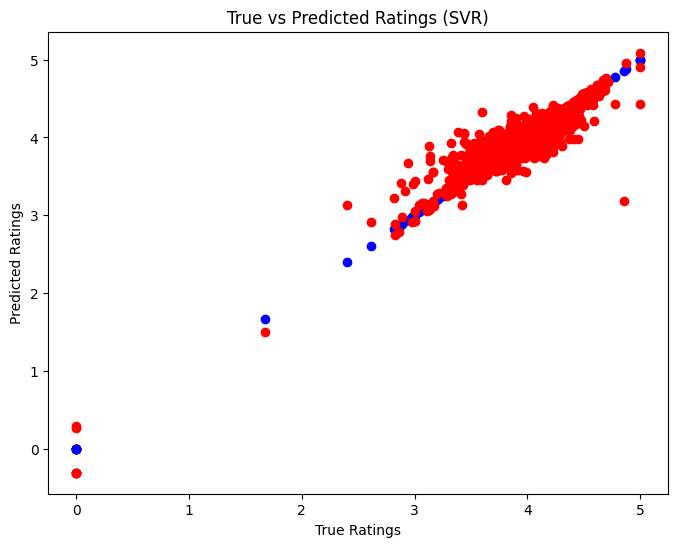

In [24]:
from sklearn.svm import SVR

# Initialize an SVR model
svr_model = SVR(kernel='linear')

# Fit the model to the training data
svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svr_model.predict(X_test)

# Create a scatter plot to visualize the predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, c='blue', label='True Ratings')
plt.scatter(y_test, y_pred, c='red', label='Predicted Ratings')
plt.xlabel("True Ratings")
plt.ylabel("Predicted Ratings")
plt.title("True vs Predicted Ratings (SVR)")
plt.show()

In [25]:
# Evaluate the model
model_eval = evaluate_model("SVR", y_test, y_pred)
models_scores = pd.concat([model_eval,models_scores.loc[:]]).reset_index(drop=True)
models_scores

,Model,MSE,RMSE,MAE,R2
0,SVR,0.015328,0.123805,0.071312,0.878511
1,Linear Regression,0.015268,0.123563,0.068662,0.878986


## KNN

Optimal k: 8


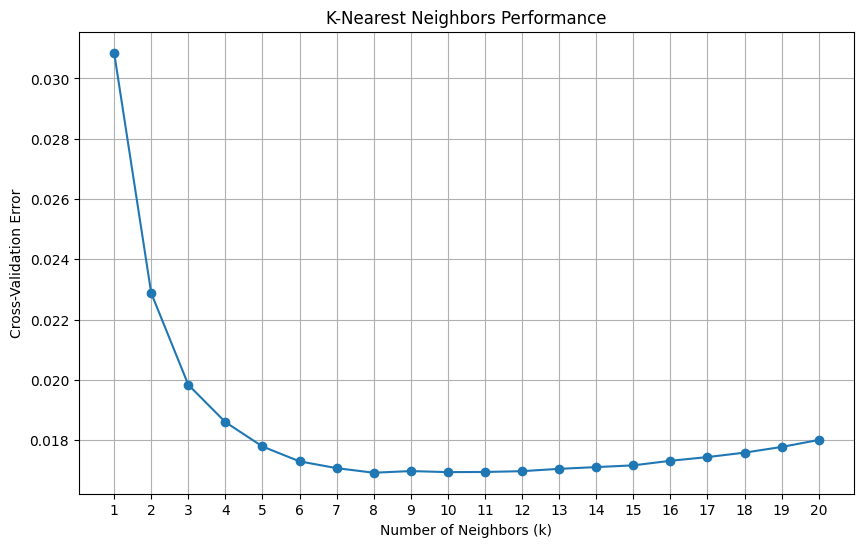

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

# Perform cross-validation to choose the best 'k'
k_values = list(range(1, 21))  # Choose a range of 'k' values to test
cv_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-np.mean(scores))

# Find the optimal 'k' with the lowest cross-validation error
optimal_k = k_values[np.argmin(cv_scores)]
print("Optimal k:", optimal_k)

# Train the KNN model with the optimal 'k' on the full training set
final_knn = KNeighborsRegressor(n_neighbors=optimal_k)
final_knn.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred = final_knn.predict(X_test)

 # Plot the performance of different 'k' values
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.title("K-Nearest Neighbors Performance")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Error")
plt.xticks(k_values)
plt.grid(True)
plt.show()

After K = 8 we can't see any progress soo we should take K= 8

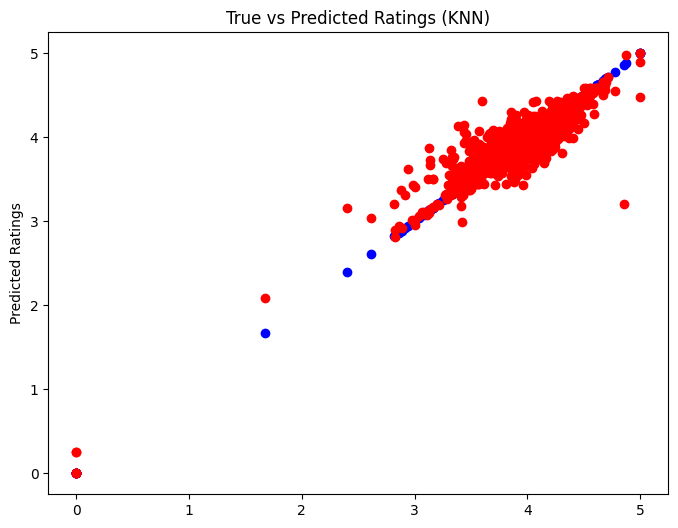

In [27]:
# Initialize a KNN Regressor model
k = 8  # Number of neighbors to consider
knn_model = KNeighborsRegressor(n_neighbors=k)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_model.predict(X_test)

# Create a scatter plot to visualize the predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, c='blue', label='True Ratings')
plt.scatter(y_test, y_pred, c='red', label='Predicted Ratings')
plt.ylabel("Predicted Ratings")
plt.title("True vs Predicted Ratings (KNN)")
plt.show()

In [28]:
# Evaluate the model
model_eval = evaluate_model("KNN", y_test, y_pred)
models_scores = pd.concat([model_eval,models_scores.loc[:]]).reset_index(drop=True)
models_scores

,Model,MSE,RMSE,MAE,R2
0,KNN,0.017000,0.130385,0.077910,0.865256
1,SVR,0.015328,0.123805,0.071312,0.878511
2,Linear Regression,0.015268,0.123563,0.068662,0.878986


## Decision tree

In [29]:
from sklearn.tree import DecisionTreeRegressor

# Create a Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Make predictions with the Decision Tree model
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
model_eval = evaluate_model("Decision Tree", y_test, y_pred)
models_scores = pd.concat([model_eval,models_scores.loc[:]]).reset_index(drop=True)
models_scores

,Model,MSE,RMSE,MAE,R2
0,Decision Tree,0.028277,0.168158,0.091604,0.775874
1,KNN,0.017000,0.130385,0.077910,0.865256
2,SVR,0.015328,0.123805,0.071312,0.878511
3,Linear Regression,0.015268,0.123563,0.068662,0.878986


## Random Forest


In [30]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

# Make predictions with the Random Forest model
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
model_eval = evaluate_model("Random Forest", y_test, y_pred)
models_scores = pd.concat([model_eval,models_scores.loc[:]]).reset_index(drop=True)
models_scores

,Model,MSE,RMSE,MAE,R2
0,Random Forest,0.020070,0.141668,0.078708,0.840925
1,Decision Tree,0.028277,0.168158,0.091604,0.775874
2,KNN,0.017000,0.130385,0.077910,0.865256
3,SVR,0.015328,0.123805,0.071312,0.878511
4,Linear Regression,0.015268,0.123563,0.068662,0.878986


## Gradient Boosting Regressor

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a Gradient Boosting Regressor
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train, y_train)

# Make predictions with the Random Forest model
y_pred = gradient_boosting_model.predict(X_test)

# Evaluate the model
model_eval = evaluate_model("Gradient Boosting", y_test, y_pred)
models_scores = pd.concat([model_eval,models_scores.loc[:]]).reset_index(drop=True)
models_scores

,Model,MSE,RMSE,MAE,R2
0,Gradient Boosting,0.015744,0.125473,0.069051,0.875216
1,Random Forest,0.020070,0.141668,0.078708,0.840925
2,Decision Tree,0.028277,0.168158,0.091604,0.775874
3,KNN,0.017000,0.130385,0.077910,0.865256
4,SVR,0.015328,0.123805,0.071312,0.878511
5,Linear Regression,0.015268,0.123563,0.068662,0.878986


In [32]:
lowest_mse_model = models_scores[models_scores['MSE'] == models_scores['MSE'].min()]['Model'].values[0]
lowest_rmse_model = models_scores[models_scores['RMSE'] == models_scores['RMSE'].min()]['Model'].values[0]
lowest_mae_model = models_scores[models_scores['MAE'] == models_scores['MAE'].min()]['Model'].values[0]
highest_r2_model = models_scores[models_scores['R2'] == models_scores['R2'].max()]['Model'].values[0]
print(f"lowest_mse_model : {lowest_mse_model}\nlowest_rmse_model : {lowest_rmse_model}\nlowest_mae_model : {lowest_mae_model}\nhighest_r2_model : {highest_r2_model}")

lowest_mse_model : Linear Regression
lowest_rmse_model : Linear Regression
lowest_mae_model : Linear Regression
highest_r2_model : Linear Regression


# Conclusion

> **Every metrics indicate that the linear regression is the best model in our situation.**

